In [42]:
%load_ext autoreload
%autoreload 2


In [4]:
! pip install datasets

  Using cached datasets-4.4.1-py3-none-any.whl.metadata (19 kB)
  Using cached httpx-0.28.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached huggingface_hub-1.1.2-py3-none-any.whl.metadata (13 kB)
  Using cached anyio-4.11.0-py3-none-any.whl.metadata (4.1 kB)
  Using cached httpcore-1.0.9-py3-none-any.whl.metadata (21 kB)
  Using cached h11-0.16.0-py3-none-any.whl.metadata (8.3 kB)
  Using cached hf_xet-1.2.0-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.9 kB)
  Using cached shellingham-1.5.4-py2.py3-none-any.whl.metadata (3.5 kB)
  Using cached typer_slim-0.20.0-py3-none-any.whl.metadata (16 kB)
  Using cached sniffio-1.3.1-py3-none-any.whl.metadata (3.9 kB)
  Using cached click-8.1.8-py3-none-any.whl.metadata (2.3 kB)
Using cached datasets-4.4.1-py3-none-any.whl (511 kB)
Using cached httpx-0.28.1-py3-none-any.whl (73 kB)
Using cached httpcore-1.0.9-py3-none-any.whl (78 kB)
Using cached huggingface_hub-1.1.2-py3-none-any.whl (514 kB)
Using cached hf_xet-1.2.0-c

In [3]:
# Download all builder configs for multiple ColliderML datasets
from datasets import load_dataset, DownloadConfig
import os
n_rows = 1000  # number of rows to download per config
custom_cache_path = "/storage/agrp/barakma/h_faces_cache"
os.environ["HF_DATASETS_CACHE"] = custom_cache_path           # datasets cache
os.environ["HF_HUB_CACHE"] = os.path.join(custom_cache_path, "hub")  # hub cache (used by streaming and scripts)
# List the dataset names you want to pull
colliderml_datasets = [
    "OpenDataDetector/ColliderML_ttbar_pu0",
    #"OpenDataDetector/ColliderML_higgs_pu0",
]
# Known configs exposed by the builder (from the error message)
builder_configs = ["particles", "tracker_hits", "calo_hits", "tracks"]
dl_cfg = DownloadConfig(
    cache_dir=custom_cache_path,
    local_files_only=True,   # do not hit the network; fail if not cached
    resume_download=True,
)
all_datasets = {}
for ds_name in colliderml_datasets:
    print(f"\n=== Dataset: {ds_name} ===")
    all_datasets[ds_name] = {}
    for cfg in builder_configs:
        print(f"Downloading config: {cfg}")
        # Each call returns a DatasetDict with train (and possibly other splits)
        all_datasets[ds_name][cfg] = load_dataset(
            ds_name,
            cfg,
            cache_dir=custom_cache_path,
            download_config=dl_cfg,
            split={"train": f"train[:{n_rows}]"},

        )
        # Basic info summary
        splits = list(all_datasets[ds_name][cfg].keys())
        print(f"  -> got splits: {splits}")
        for split in splits[:1]:  # just first split for brevity
            print(
                f"     {cfg}/{split}: {len(all_datasets[ds_name][cfg][split])} rows"
            )

print("\nCompleted downloads. Access structure like: all_datasets['OpenDataDetector/ColliderML_ttbar_pu0']['particles']['train'][:5]")

/storage/agrp/barakma/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



=== Dataset: OpenDataDetector/ColliderML_ttbar_pu0 ===
  -> got splits: ['train']
     particles/train: 1000 rows
  -> got splits: ['train']
     tracker_hits/train: 1000 rows
  -> got splits: ['train']
     calo_hits/train: 1000 rows
  -> got splits: ['train']
     tracks/train: 1000 rows

Completed downloads. Access structure like: all_datasets['OpenDataDetector/ColliderML_ttbar_pu0']['particles']['train'][:5]


In [101]:
all_datasets
# pickle it and save, first gzip it 
import pickle
import gzip
with gzip.open('all_datasets.pkl.gz', 'wb') as f:
    pickle.dump(all_datasets, f)

 

In [1]:
# read it back
import pickle
import gzip
with gzip.open('all_datasets.pkl.gz', 'rb') as f:
    all_datasets_loaded = pickle.load(f)   

/storage/agrp/barakma/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


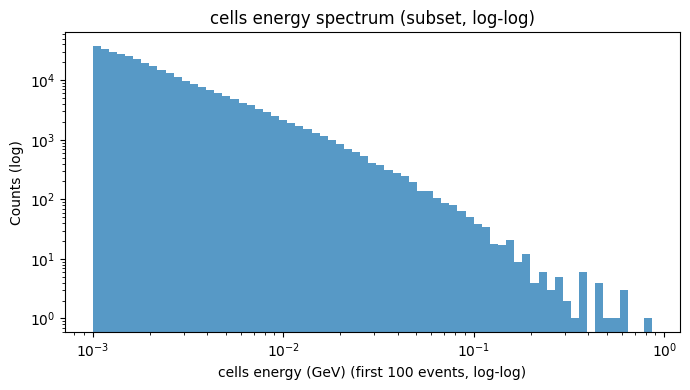

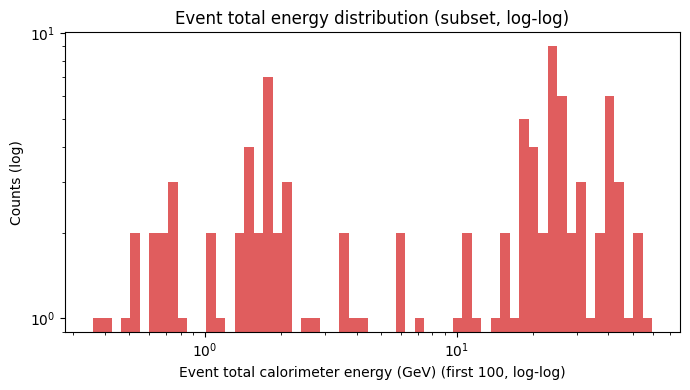

In [4]:
# ...existing code...
import numpy as np
import matplotlib.pyplot as plt
dataset = all_datasets_loaded['OpenDataDetector/ColliderML_ttbar_pu0']
calo_e = dataset['calo_hits']['train'].with_format('numpy')
N_events = 100
total_energy_events = calo_e['total_energy'][:N_events]

# Cluster energies (subset)
all_E_N = np.concatenate([np.asarray(e, dtype=float) for e in total_energy_events])
all_E_N = all_E_N[all_E_N > 0]

# Log-spaced bins for x (energy)
bins_E = np.geomspace(max(all_E_N.min(), 1e-3), all_E_N.max(), 70)

plt.figure(figsize=(7,4))
plt.hist(all_E_N, bins=bins_E, color="#1f77b4", alpha=0.75)
plt.xscale("log")
plt.yscale("log")
plt.xlabel(f"cells energy (GeV) (first {N_events} events, log-log)")
plt.ylabel("Counts (log)")
plt.title("cells energy spectrum (subset, log-log)")
plt.tight_layout()
plt.show()

# Per-event total energy (subset)
event_sum_E_N = np.array([np.sum(np.asarray(e, dtype=float)) for e in total_energy_events])
event_sum_E_N = event_sum_E_N[event_sum_E_N > 0]

bins_evt = np.geomspace(max(event_sum_E_N.min(), 1e-3), event_sum_E_N.max(), 60)

plt.figure(figsize=(7,4))
plt.hist(event_sum_E_N, bins=bins_evt, color="#d62728", alpha=0.75)
plt.xscale("log")
plt.yscale("log")
plt.xlabel(f"Event total calorimeter energy (GeV) (first {N_events}, log-log)")
plt.ylabel("Counts (log)")
plt.title("Event total energy distribution (subset, log-log)")
plt.tight_layout()
plt.show()
# ...existing code...

In [10]:
from cluster.helpers.meanshift_mod import  MeanShiftMod

In [11]:
m = MeanShiftMod(bin_seeding=True, bandwidth=0.4)

In [7]:
import importlib, inspect
import cluster.play as play
all_datasets = all_datasets_loaded 
# Ensure latest code is loaded (even if previously imported)
play = importlib.reload(play)
from cluster.play import get_points_for_clustering
points= get_points_for_clustering(all_datasets, until_index=1,energy_threshold=0.00005)[0]

In [74]:
points.shape

(15906, 2)

In [75]:
m.fit(points)

/storage/agrp/barakma/.venv/lib64/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


MeanShiftMod(bandwidth=0.4, bin_seeding=True)

In [82]:
m.labels_

array([ 1,  1,  1, ...,  2,  2, 19])

n_clusters: 45
centers shape: (45, 2)
cluster counts: {0: 3394, 1: 2998, 2: 2528, 3: 2042, 4: 2239, 5: 627, 6: 417, 7: 224, 8: 184, 9: 168, 10: 127, 11: 116, 12: 65, 13: 57, 14: 55, 15: 56, 16: 243, 17: 44, 18: 33, 19: 30, 20: 30, 21: 28, 22: 28, 23: 10, 24: 15, 25: 12, 26: 9, 27: 8, 28: 6, 29: 4, 30: 5, 31: 4, 32: 46, 33: 3, 34: 2, 35: 2, 36: 8, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 32, 43: 1, 44: 1}


,eta_center,phi_center,count
0,-2.061814,-1.024757,3394
1,-0.354226,2.065625,2998
2,-0.216925,0.380426,2528
3,-1.099003,-1.783453,2042
4,-0.923035,1.169198,2239


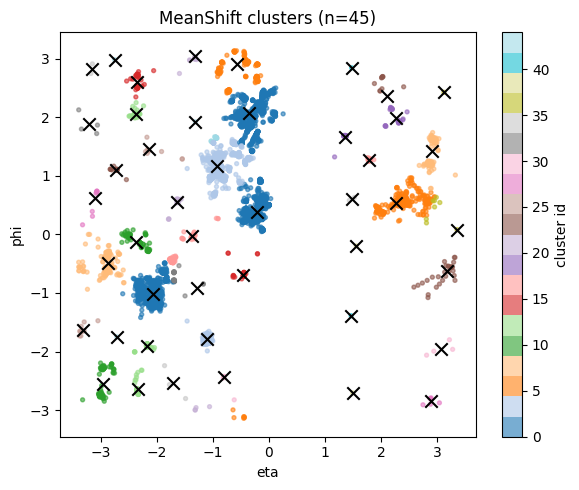

In [76]:
# ...existing code...
# Inspect MeanShift results
import numpy as np

labels = m.labels_
centers = m.cluster_centers_
n_clusters = len(np.unique(labels))
print("n_clusters:", n_clusters)
print("centers shape:", centers.shape)

# Per-cluster counts
unique, counts = np.unique(labels, return_counts=True)
print("cluster counts:", dict(zip(unique, counts)))

# Optional: build a summary table
import pandas as pd
summary = pd.DataFrame(centers, columns=["eta_center", "phi_center"])
summary["count"] = [counts[np.where(unique==i)[0][0]] for i in range(n_clusters)]
display(summary.head())

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(6,5))
sc = plt.scatter(points[:,0], points[:,1], c=labels, s=8, cmap="tab20", alpha=0.6)
plt.scatter(centers[:,0], centers[:,1], c="k", s=80, marker="x")
plt.xlabel("eta")
plt.ylabel("phi")
plt.title(f"MeanShift clusters (n={n_clusters})")
plt.colorbar(sc, label="cluster id")
plt.tight_layout()
plt.show()
# ...existing code...

In [ ]:
from cluster.plot import plot_calo_clusters_3d, plot_calo_clusters_3d_given
import cluster.plot as cplot
import importlib

importlib.reload(cplot)
dataset_name="OpenDataDetector/ColliderML_ttbar_pu0"
event_idx=0
bandwidth=0.4
energy_threshold=0.00005
calo = all_datasets[dataset_name]["calo_hits"]["train"].with_format("numpy")
points_list = get_points_for_clustering(all_datasets, dataset_name=dataset_name, energy_threshold=energy_threshold, until_index=event_idx+1)
data = points_list[event_idx]['points']



NameError: name 'MeanShiftMod' is not defined

In [12]:
import importlib
import nbformat
importlib.reload(nbformat)  
ms = MeanShiftMod(bandwidth=bandwidth, bin_seeding=True).fit(data)


/storage/agrp/barakma/.venv/lib64/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


{'OpenDataDetector/ColliderML_ttbar_pu0': {'particles': DatasetDict({
      train: Dataset({
          features: ['event_id', 'particle_id', 'pdg_id', 'mass', 'energy', 'charge', 'vx', 'vy', 'vz', 'time', 'px', 'py', 'pz', 'vertex_primary', 'parent_id'],
          num_rows: 1000
      })
  }),
  'tracker_hits': DatasetDict({
      train: Dataset({
          features: ['event_id', 'x', 'y', 'z', 'true_x', 'true_y', 'true_z', 'time', 'particle_id', 'cell_id', 'detector', 'volume_id', 'layer_id', 'surface_id'],
          num_rows: 1000
      })
  }),
  'calo_hits': DatasetDict({
      train: Dataset({
          features: ['event_id', 'detector', 'total_energy', 'x', 'y', 'z', 'contrib_particle_ids', 'contrib_energies', 'contrib_times'],
          num_rows: 1000
      })
  }),
  'tracks': DatasetDict({
      train: Dataset({
          features: ['event_id', 'd0', 'z0', 'phi', 'theta', 'qop', 'majority_particle_id', 'hit_ids', 'track_id'],
          num_rows: 1000
      })
  })}}

In [17]:
import importlib
import cluster.plot
importlib.reload(cluster.plot)
from cluster.plot import plot_calo_clusters_3d, plot_calo_clusters_3d_given


plot_calo_clusters_3d_given(event_idx, points_list, ms, all_datasets, dataset_name=dataset_name, show=True)

(array([ 1,  1,  1, ...,  7, 10,  7]),
 array([[-2.0618138 , -1.024757  ],
        [-0.3542263 ,  2.0656254 ],
        [-0.21692534,  0.38042617],
        [-1.0990026 , -1.7834526 ],
        [-0.9230346 ,  1.1691977 ],
        [ 2.2717593 ,  0.5289906 ],
        [-0.575562  ,  2.9050148 ],
        [-2.8628218 , -0.4825558 ],
        [ 2.8983295 ,  1.4257901 ],
        [-2.3675969 , -0.12428108],
        [-2.964388  , -2.5473728 ],
        [-2.3752413 ,  2.0529094 ],
        [-2.178975  , -1.900972  ],
        [-2.3407173 , -2.6461496 ],
        [-2.3418758 ,  2.6079683 ],
        [-0.46666464, -0.69120926],
        [-1.3779957 , -0.03516723],
        [ 1.7845757 ,  1.2712265 ],
        [ 2.2543983 ,  1.9906055 ],
        [ 1.3541298 ,  1.6685809 ],
        [-1.3109164 ,  3.0479953 ],
        [-1.6364706 ,  0.549935  ],
        [ 3.165858  , -0.62818384],
        [ 2.1067007 ,  2.3702974 ],
        [-2.732148  ,  1.0995232 ],
        [-3.3124325 , -1.6309329 ],
        [-2.1289651 ,  1.

In [93]:
! pip install "nbformat>=4.2.0" 

In [36]:
from datasets import load_dataset
import json
import numpy as np

# Load the four configurations (replace with full split if needed)
particles = all_datasets["OpenDataDetector/ColliderML_ttbar_pu0"]["particles"]["train"].with_format("numpy")
tracker_hits = all_datasets["OpenDataDetector/ColliderML_ttbar_pu0"]["tracker_hits"]["train"].with_format("numpy")
calo_hits = all_datasets["OpenDataDetector/ColliderML_ttbar_pu0"]["calo_hits"]["train"].with_format("numpy")
tracks = all_datasets["OpenDataDetector/ColliderML_ttbar_pu0"]["tracks"]["train"].with_format("numpy")

phoenix_data = {}

for i in range(1):
    event_id = particles[i]['event_id']
    event_key = f"Event {event_id}"
    event_data = {
        "event number": event_id,
        "run number": 0  # Placeholder; set to actual run if available
    }

    # Hits from tracker_hits
    hits = []
    for j in range(len(tracker_hits[i]['x'])):
        hit = {
            "pos": [tracker_hits[i]['x'][j], tracker_hits[i]['y'][j], tracker_hits[i]['z'][j]],
            "time": tracker_hits[i]['time'][j],
            "particle_id": tracker_hits[i]['particle_id'][j]
        }
        hits.append(hit)
    event_data["Hits"] = {"TrackerHits": hits}

    # Clusters from calo_hits
    clusters = []
    for j in range(len(calo_hits[i]['total_energy'])):
        cluster = {
            "pos": [calo_hits[i]['x'][j], calo_hits[i]['y'][j], calo_hits[i]['z'][j]],
            "e": calo_hits[i]['total_energy'][j]
        }
        clusters.append(cluster)
    event_data["Clusters"] = {"CaloClusters": clusters}

    # Tracks from tracks
    track_list = []
    for j in range(len(tracks[i]['d0'])):
        qop = tracks[i]['qop'][j]
        track = {
            "d0": tracks[i]['d0'][j],
            "z0": tracks[i]['z0'][j],
            "phi": tracks[i]['phi'][j],
            "theta": tracks[i]['theta'][j],
            "qop": qop,
            "charge": 1 if qop > 0 else -1  # Derived from qop sign
        }
        track_list.append(track)
    event_data["Tracks"] = {"ReconstructedTracks": track_list}

    # Vertices from particles (primary only)
    vertices = []
    for j in range(len(particles[i]['vx'])):
        if particles[i]['vertex_primary'][j] > 0:
            vertex = {
                "pos": [particles[i]['vx'][j], particles[i]['vy'][j], particles[i]['vz'][j]]
            }
            vertices.append(vertex)
    if vertices:
        event_data["Vertices"] = {"PrimaryVertices": vertices}

    phoenix_data[event_key] = event_data

# Save to JSON
with open("collider_ml_phoenix.json", "w") as f:
    json.dump(phoenix_data, f, indent=4)

print("JSON file generated: collider_ml_phoenix.json")

KeyboardInterrupt: 